<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Drft_Diffusion_conformal_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a_e*L = 1.000,   a_i*L = 5.000  (keep these ~O(1..5) to avoid blow-up)


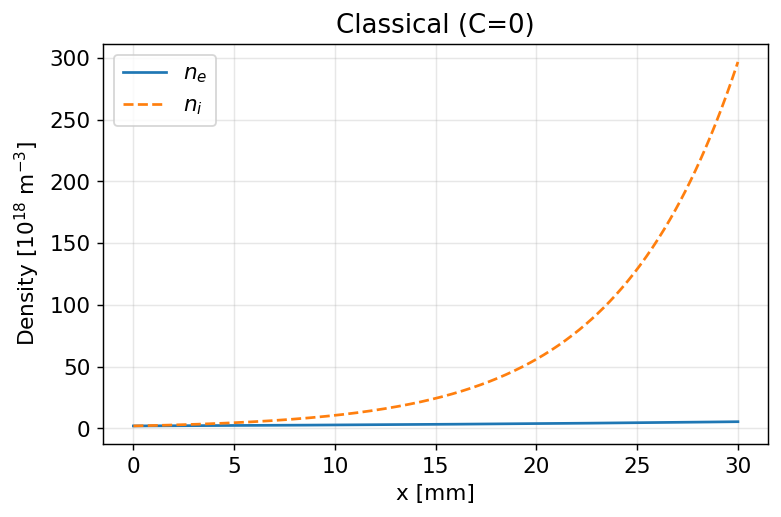

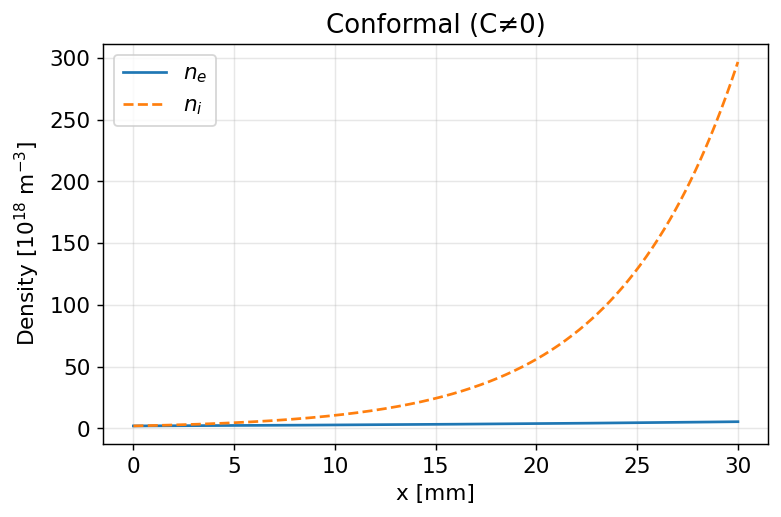

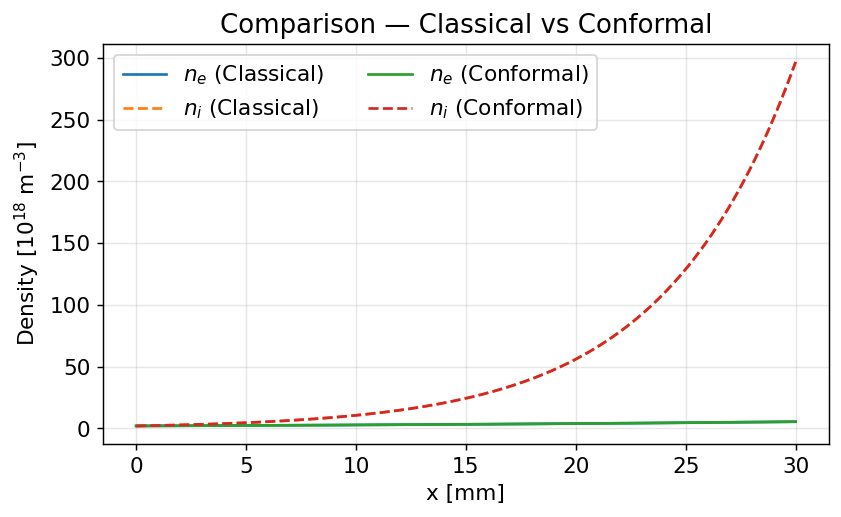


Exit densities (x = L):
Electrons:  n(L)_cls = 5.437e+18  |  n(L)_conf = 5.437e+18  |  Δ = 0.000e+00  (0.000%)
Ions     :  n(L)_cls = 2.968e+20  |  n(L)_conf = 2.968e+20  |  Δ = 0.000e+00  (0.000%)

Flux check (Classical (C=0)):
  electrons:  target j_e = -8.000e+01 A/m^2,  implied mean = 1.867e+15 A/m^2
  ions     :  target j_i = 8.000e+01 A/m^2,  implied mean = 3.342e+17 A/m^2

Flux check (Conformal (C≠0)):
  electrons:  target j_e = -8.000e+01 A/m^2,  implied mean = 1.867e+15 A/m^2
  ions     :  target j_i = 8.000e+01 A/m^2,  implied mean = 3.342e+17 A/m^2


In [ ]:
# ==============================================================
# Drift–Diffusion in a Hall-like 1D slab (flux-driven, analytic, stable)
# Electrons & ions; neutrals are fixed background (not evolved).
# Compare: Classical (C=0) vs Conformal drive (C≠0, uniform).
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e

plt.rcParams.update({"figure.dpi": 130, "font.size": 12})

# --------------------------------------------------------------
# Self-consistent parameters (chosen to keep a*L modest)
# --------------------------------------------------------------
L   = 0.03     # [m] channel length (3 cm)
Va  = 5.0      # [V] anode potential  ->  small field to avoid exp blow-up
E0  = (Va - 0.0)/L  # uniform axial field [V/m] ~ 166.7 V/m

# Boundary density at anode (x=0)
n0  = 2.0e18   # [1/m^3]

# Prescribed species fluxes (flux-driven)
j_i = +80.0    # [A/m^2] ions toward +x
j_e = -80.0    # [A/m^2] electrons toward -x

# Conformal drive: C_NS_x = -12 * kappa_C * |b|, uniform along +x
kappa_C  = 1e-19
C_uniform = -12.0 * kappa_C  # [N/m^3]

# Neutrals (fixed background; informative only)
n_n = 1.0e19  # [1/m^3]

# Species & transport (unmagnetized axial)
me = 9.10938356e-31
mi = 131.293 * 1.66053906660e-27  # ~Xe+
Te_eV = 5.0;  Te = Te_eV * e
Ti_eV = 1.0;  Ti = Ti_eV * e

# Effective momentum exchange frequencies (tuned to keep μ, D reasonable)
nu_e = 5e10
nu_i = 5e5

# Mobilities (μ = q/(m*nu)) and diffusion (Einstein D = T/(m*nu))
mu_e = e/(me * nu_e)
mu_i = e/(mi * nu_i)
De   = Te/(me * nu_e)
Di   = Ti/(mi * nu_i)

# Quick sanity check of exponential coefficient a = e*E0/T_s (independent of mass, nu)
a_e = e*E0/Te     # [1/m]
a_i = e*E0/Ti     # [1/m]
print(f"a_e*L = {a_e*L:.3f},   a_i*L = {a_i*L:.3f}  (keep these ~O(1..5) to avoid blow-up)")

# --------------------------------------------------------------
# Analytic solution for steady 1D drift–diffusion with constant E:
#   j = μ n E0 - D n' + C/(m ν)   ⇒  n' = a n + b
#   where a = (μ E0)/D,   b = (C/(m ν) - j)/D  (constants)
#
#   If a ≠ 0:  n(x) = (n0 + b/a) * exp(a x) - b/a
#   If a = 0:  n(x) = n0 + b * x
# --------------------------------------------------------------
def density_profile_analytic(x, n0, mu, D, m, nu, E0, j_const, C_NS):
    a = (mu * E0) / D             # = e*E0/T_s (Einstein)
    b = (C_NS/(m * nu) - j_const) / D
    if np.isclose(a, 0.0):
        n = n0 + b * x
    else:
        n = (n0 + b/a) * np.exp(a * x) - b/a
    return n

def species_profiles(x, n0, mu, D, m, nu, j_const, E0, C_list):
    prof = {}
    for name, Cval in C_list.items():
        n = density_profile_analytic(x, n0, mu, D, m, nu, E0, j_const, Cval)
        prof[name] = n
    return prof

# Build grid and cases
x = np.linspace(0.0, L, 600)
cases = {
    "Classical (C=0)": 0.0,
    "Conformal (C≠0)": C_uniform
}

# Compute profiles
ne_profiles = species_profiles(x, n0, mu_e, De, me, nu_e, j_e, E0, cases)
ni_profiles = species_profiles(x, n0, mu_i, Di, mi, nu_i, j_i, E0, cases)

# --------------------------------------------------------------
# Plot per case
# --------------------------------------------------------------
def plot_case(title, ne, ni):
    plt.figure(figsize=(6.6,4))
    plt.plot(x*1e3, ne/1e18, label=r"$n_e$")
    plt.plot(x*1e3, ni/1e18, '--', label=r"$n_i$")
    plt.xlabel("x [mm]")
    plt.ylabel(r"Density [$10^{18}$ m$^{-3}$]")
    plt.title(title)
    plt.grid(alpha=0.3); plt.legend()
    plt.show()

for name in cases.keys():
    plot_case(name, ne_profiles[name], ni_profiles[name])

# Overlay comparison (to visualize the effect)
plt.figure(figsize=(7.2,4))
plt.plot(x*1e3, ne_profiles["Classical (C=0)"]/1e18, label=r"$n_e$ (Classical)")
plt.plot(x*1e3, ni_profiles["Classical (C=0)"]/1e18, '--', label=r"$n_i$ (Classical)")
plt.plot(x*1e3, ne_profiles["Conformal (C≠0)"]/1e18, label=r"$n_e$ (Conformal)")
plt.plot(x*1e3, ni_profiles["Conformal (C≠0)"]/1e18, '--', label=r"$n_i$ (Conformal)")
plt.xlabel("x [mm]")
plt.ylabel(r"Density [$10^{18}$ m$^{-3}$]")
plt.title("Comparison — Classical vs Conformal")
plt.grid(alpha=0.3); plt.legend(ncol=2)
plt.show()

# --------------------------------------------------------------
# Exit values & flux consistency check
# --------------------------------------------------------------
def report_exit(tag, n_classical, n_conformal):
    nL_cls = n_classical[-1]
    nL_con = n_conformal[-1]
    delta  = nL_con - nL_cls
    frac   = delta / max(nL_cls, 1e-30)
    print(f"{tag}:  n(L)_cls = {nL_cls:.3e}  |  n(L)_conf = {nL_con:.3e}  |  Δ = {delta:.3e}  ({frac:.3%})")

print("\nExit densities (x = L):")
report_exit("Electrons", ne_profiles["Classical (C=0)"], ne_profiles["Conformal (C≠0)"])
report_exit("Ions     ", ni_profiles["Classical (C=0)"], ni_profiles["Conformal (C≠0)"])

# Check that the implied flux is (approximately) constant and equals j_s
def implied_flux(n, mu, D, m, nu, j_const, C_NS):
    dn_dx = np.gradient(n, x)
    return mu*n*E0 - D*dn_dx + C_NS/(m*nu)

for name, Cval in cases.items():
    je_imp = implied_flux(ne_profiles[name], mu_e, De, me, nu_e, j_e, Cval)
    ji_imp = implied_flux(ni_profiles[name], mu_i, Di, mi, nu_i, j_i, Cval)
    print(f"\nFlux check ({name}):")
    print(f"  electrons:  target j_e = {j_e:.3e} A/m^2,  implied mean = {je_imp.mean():.3e} A/m^2")
    print(f"  ions     :  target j_i = {j_i:.3e} A/m^2,  implied mean = {ji_imp.mean():.3e} A/m^2")
